To compute Owen values of a model, a partition of the predictors should be provided. In our numerical experiments, we applied our proprietary code for estimating marginal Owen values to CatBoost models trained in Section 4.2 on public datasets ([Superconductivity](https://archive.ics.uci.edu/ml/datasets/superconductivty+data), [Ailerons](https://www.dcc.fc.up.pt/~ltorgo/Regression/ailerons.html), [Online News Popularity](https://archive.ics.uci.edu/ml/datasets/online+news+popularity) and [Higgs](https://archive.ics.uci.edu/ml/datasets/HIGGS)). To partition the predictors based on dependencies, a hierarchical clustering algorithm was used based on the [Maximal Information Coefficient](https://jmlr.org/papers/v17/15-308.html), a state-of-the-art measure of dependence capable of capturing non-linear relations between the variables (see [here](https://arxiv.org/abs/2102.10878v4) for more on this procedure). The resulting partitions and dendrograms are saved in folders `Dendrograms` and `Partitions` respectively. This notebook demonstrates how the features are partitioned for one of the public datasets. It can easily be adapted to any other dataset with slight changes (like updating feature names). The source code is available from `ai_utils.py`. 

In [1]:
import os
import minepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from copy import copy
from scipy.cluster import hierarchy
from ai_utils import mic_clustering
from ai_utils import get_sliced_partition

In [2]:
dataset_name = 'Airelons'

feature_names = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
         'SeTime1', 'SeTime2', 'SeTime3', 'SeTime4', 'SeTime5', 'SeTime6', 'SeTime7', 'SeTime8', 'SeTime9', 
         'SeTime10', 'SeTime11', 'SeTime12', 'SeTime13', 'SeTime14', 'DiffSeTime1', 'DiffSeTime2', 'DiffSeTime3', 
         'DiffSeTime4', 'DiffSeTime5', 'DiffSeTime6', 'DiffSeTime7', 'DiffSeTime8', 'DiffSeTime9', 'DiffSeTime10', 
         'DiffSeTime11', 'DiffSeTime12', 'DiffSeTime13', 'DiffSeTime14', 'Alpha', 'Se']

df = pd.read_csv('ailerons_data.csv',usecols = feature_names)


Building the MIC tree (using 5000 data samples)...
Done.

Printing the nested partitions:
height = 0.00000, partition = [[25], [27], [29], [31], [26], [28], [30], [32], [34], [36], [24], [1], [6], [5], [8], [0], [4], [38], [23], [39], [21], [22], [19], [20], [10], [17], [18], [11], [12], [13], [14], [15], [16], [3], [7], [2], [9], [33], [35], [37]]
height = 0.00028, partition = [[25], [27], [29], [31], [26], [28], [30], [32], [34], [36], [24], [1], [6], [5], [8], [0], [4], [38], [21], [22], [19], [20], [10], [17], [18], [11], [12], [13], [14], [15], [16], [3], [7], [2], [9], [33], [35], [37], [39, 23]]
height = 0.00031, partition = [[25], [27], [29], [31], [26], [28], [30], [32], [34], [36], [24], [1], [6], [5], [8], [0], [4], [38], [19], [20], [10], [17], [18], [11], [12], [13], [14], [15], [16], [3], [7], [2], [9], [33], [35], [37], [39, 23], [21, 22]]
height = 0.00036, partition = [[25], [27], [29], [31], [26], [28], [30], [32], [34], [36], [24], [1], [6], [5], [8], [0], [4], [38],

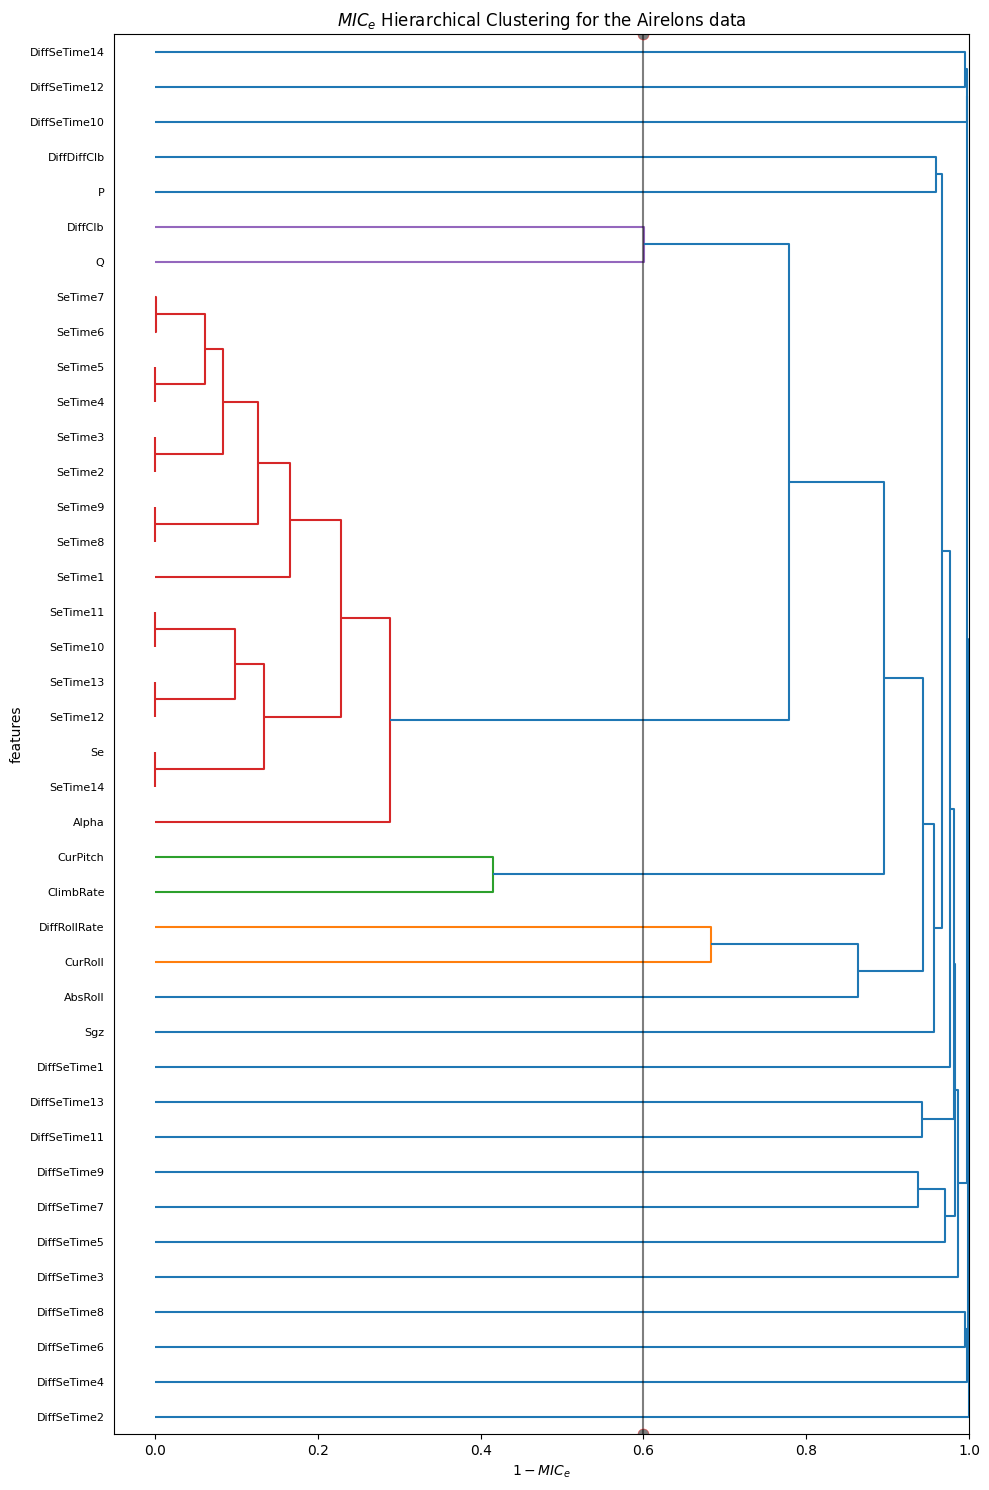

In [3]:
# specify number of samples:
N = int(max(df.shape[0]*0.002,5000))
X = df.sample(n=N,random_state=1234)
dendrogram_labels = feature_names

print("\nBuilding the MIC tree (using {0} data samples)...".format(X.shape[0]))
result = mic_clustering(data=X)
print("Done.")

mic_linkage = result['linkage']
partitions_info = result['partitions_info']

# printing nested partitions:
print("\nPrinting the nested partitions:")
for j in range(len(partitions_info)):
    print('height = {0:.5f},'.format(partitions_info[j]['height']), 'partition =', partitions_info[j]['partition'])
    
threshold = 0.6
print("\nSlicing the tree at threshold t={0}:".format(threshold))
partition = get_sliced_partition(partitions_info, threshold)
print("partition({0}) =".format(threshold), partition)

with open(f'Partitions/Partition_{dataset_name}.json','w') as file:
    json.dump(partition,file)
    
###################################################

dim = X.shape[1]
plt.figure(figsize=(10, 15))
hierarchy.dendrogram(mic_linkage, labels=dendrogram_labels, orientation='right')
plt.xlabel('$1 - MIC_e$')
plt.ylabel('features')
plt.xlim([-0.05, 1])
plt.title(f'$MIC_e$ Hierarchical Clustering for the {dataset_name} data')
plt.tight_layout()
plt.plot([threshold, threshold],[0, dim*10],
            color='black',
            marker='o', 
            markersize=8, 
            markeredgewidth=0.5, 
            markeredgecolor="red",
            linestyle="solid", alpha=0.5)
plt.savefig(f'./Dendrograms/Dendrogram_{dataset_name}')
plt.show()